In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
%load_ext autoreload
%autoreload 2
from RTKToArrayConversion import *
from ConeBeamDCCWithBackprojectionPlane import *
from AllAcquisitionBPClass import *
from TextFileSaving import *

def moving_average(x, y, w):
    ma = np.zeros(x.shape)
    weights = np.zeros(x.shape)
    for i in range(x.shape[0]):
#         print(len(np.where(np.abs(x-x[i]) <= w//2)[0]))
        ma[i] += np.mean(y[np.where(np.abs(x-x[i]) <= w//2)])
#         weights[i] += len(np.where(np.abs(x-x[i]) <= w//2)[0])
    return ma

In [3]:
filesdir_ref = "/home/mmouchet/Documents/SIEMENSDATA/GO.SIM/phantom/14_01_22/4D/sans_table/donneesBrutes/P007_Trot035_Tresp0/"
# reading projections
proj = itk.imread(filesdir_ref+"proj_874_958.mha")
# Reading the geometry of the scanner
xmlreader = rtk.ThreeDCircularProjectionGeometryXMLFileReader.New()
xmlreader.SetFilename(filesdir_ref+'geometry_874_958.xml')
# xmlreader.SetFilename(filesdir_ref+"geometry.xml")
xmlreader.GenerateOutputInformation()
geometry = xmlreader.GetOutputObject()
print('nproj = %d'%(len(geometry.GetGantryAngles())))
print(proj.GetLargestPossibleRegion().GetSize())

nproj = 74588
itkSize3 ([920, 32, 74588])


In [4]:
# shrinkage
# ImageType = itk.Image[itk.F,3]
# rebin = itk.BinShrinkImageFilterrespi_libre[ImageType,ImageType].New()
# rebin.SetInput(proj)
# rebin.SetShrinkFactor(0,10)
# rebin.Update()
# proj_rebin = rebin.GetOutput()
# itk.imwrite(proj_rebin,filesdir_ref + 'projections_thorax_360_2rot_920x1028_shrink10_a160.mha')
# print(proj_rebin.GetSpacing())

# I0=10**5
# dH2O=0.01879 #mm^-1 at 75 keV
# if I0!=0:
#     new_sino = I0*np.exp(-1.*dH2O*itk.GetArrayFromImage(proj_rebin))
#     new_sino = np.maximum(np.random.poisson(new_sino), 1)
#     new_sino = np.log(I0/new_sino)/dH2O
#     proj_rebin_n = itk.GetImageFromArray(new_sino.astype(np.float32))
#     proj_rebin_n.CopyInformation(proj_rebin)
#     proj_rebin_n.Update()
#     itk.imwrite(proj_rebin_n,filesdir_ref + 'projections_thorax_360_2rot_920x1028_shrink10_a160_noise.mha') 

In [5]:
#Convert to array for faster computation
geometry_array = RTKtoNP(geometry)
proj_array = itk.GetArrayFromImage(proj)
proj_infos = GetProjectionInformations(proj)
source_pos_array = GetSourcePositions(geometry)
rotation_matrices_array = GetRotationMatrices(geometry)
fixed_matrices_array = GetFixedSystemMatrices(geometry)
print(proj_infos)
AcquiDCC = DCCWithBPinAnAcquisition(geometry_array, source_pos_array, rotation_matrices_array, fixed_matrices_array, proj_array, proj_infos)

[array([1.02806101, 1.0947541 , 1.        ]), array([0., 0., 0.]), array([  920,    32, 74588]), array([[ 1.,  0.,  0.],
       [ 0., -1.,  0.],
       [ 0.,  0.,  1.]])]


In [6]:
from joblib import Parallel, delayed
from tqdm import tqdm_notebook
import time

ref = 37294
print(geometry_array[8,0],geometry_array[8, ref])
N = AcquiDCC.axial_limit
# N = 420
res = []
idx = []
times = []

for i in tqdm_notebook(range(-AcquiDCC.n_proj_per_rotation,AcquiDCC.n_proj_per_rotation)):
    if ref == i+ref or i+ref <0 or i+ref >= proj_infos[2][2] or np.abs(geometry_array[2, ref]-geometry_array[2, ref+i]) <10**(-12):
        pass
    elif AcquiDCC.CheckPairGeometry(ref, i+ref) != 0 :
        g0 = NPtoRTK(AcquiDCC.geometry, ref)
        g1 = NPtoRTK(AcquiDCC.geometry, i+ref)
        p0 = ARRAYtoRTK(AcquiDCC.projections, AcquiDCC.proj_spacing, AcquiDCC.proj_origin, AcquiDCC.proj_size, AcquiDCC.proj_direction, ref)
        p1 = ARRAYtoRTK(AcquiDCC.projections, AcquiDCC.proj_spacing, AcquiDCC.proj_origin, AcquiDCC.proj_size, AcquiDCC.proj_direction, i+ref)
#         start = time.time()
        pair_bp = ProjectionsPairBP(ref, i+ref, g0, g1, p0, p1, AcquiDCC.spiral_dir)
        pair_bp.LinesMomentsCorners()
#         end = time.time()-start
        idx.append(i+ref)
        res.append([pair_bp.m0, pair_bp.m1])
#         times.append(end)
# len(times), np.mean(times), np.std(times)  

957.98 916.03


This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


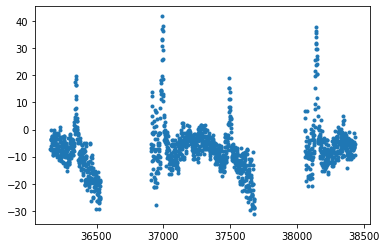

In [7]:
plt.figure()
plt.plot(idx,[np.mean(res[i][0])-np.mean(res[i][1]) for i in range(len(idx))], '.')
plt.show()

In [8]:
savedir = "/home/mmouchet/Documents/Report/thesis/simu/mechanical_phantom/"
WriteBPMomentsFile(savedir+"Tresp0_proj37294_rot_BP",idx,res)

0

In [ ]:
import matplotlib.pyplot as plt
%matplotlib notebook
# plot results
def motion(t):
    return 0.1608 + 0.936*np.cos(2*np.pi*t-np.pi) + 0.2808*np.cos(4*np.pi*t-3*np.pi/4) + 0.03744*np.cos(6*np.pi*t - np.pi/3) + 0.03744*np.cos(8*np.pi*t+np.pi/2) +0.013104*np.cos(10*np.pi*t+np.pi)


# plt.figure()
# plt.title(r"Moments absolute difference with ref at $z$ = %.2f mm" %(geometry_array[8, ref]))
# plt.plot(geometry_array[8, idx], [np.sum(np.abs(res[i][0] - res[i][1]))/len(res[i][0]) for i in range(len(res))],'+')
# # plt.plot(geometry_array[8, idx], moving_average(np.array(idx),np.array([np.sum(np.abs(res[i][0] - res[i][1]))/len(res[i][0]) for i in range(len(res))]),AcquiDCC.n_proj_per_rotation))
# plt.xlabel(r"$z(mm)$")
# plt.ylabel(r"$\frac{1}{K} \sum_k |M_k(\lambda)-M_k(\lambda')|$")
# plt.axhline(y=0, color='k', linewidth=0.5)
# plt.show()

plt.figure()
plt.title(r"Moments absolute difference with ref at $z$ = %.2f mm" %(geometry_array[8, ref]))
plt.plot(np.array(idx), [np.sum((res[i][0] - res[i][1]))/len(res[i][0]) for i in range(len(res))])
plt.plot(np.array(idx), moving_average(np.array(idx),np.array([np.sum((res[i][0] - res[i][1]))/len(res[i][0]) for i in range(len(res))]),AcquiDCC.n_proj_per_rotation))
plt.xlabel(r"$z(mm)$")
plt.ylabel(r"$\frac{1}{K} \sum_k |M_k(\lambda)-M_k(\lambda')|$")
plt.axhline(y=0, color='k', linewidth=0.5)
plt.show()

# plt.figure()
# plt.plot(np.array(idx),geometry_array[2,idx]%np.pi,'+')
# plt.show()



In [ ]:
savedir = "/home/mmouchet/Documents/SIEMENSDATA/GO.SIM/phantom/14_12_21/4D/stats_report2/"
# savedir = "/home/mmouchet/PycharmProjects/4D_study/bpm_12/"
WriteMomentsFile(savedir+"Tresp4_sub288_corr_on29001_n33199_proj9322_BP_FOV",idx,res)




In [ ]:
%matplotlib notebook
savedir = "/home/mmouchet/Documents/SIEMENSDATA/GO.SIM/phantom/14_12_21/4D/stats_report2/"
#ib
idx0, ib0 = ReadMoments(savedir+"Tresp0_sub288_corr_on29001_n31704_proj6000_HannWover10")
idx1, ib1 = ReadMoments(savedir+"Tresp0_sub288_corr_on29001_n31704_proj6000_BP")
# idx2, ib2 = ReadMoments(savedir+"Tresp0_sub288_corr_on29001_n31704_proj6000_HannWover10")
# idx3, ib3 = ReadMoments(savedir+"Tresp4_sub288_corr_on29001_n29001_proj0_HannWover10")
# idx4, ib4 = ReadMoments(savedir+"Tresp4_sub288_corr_on29001_n30349_proj3000_HannWover10")
# idx5, ib5 = ReadMoments(savedir+"Tresp4_sub288_corr_on29001_n31704_proj6000_HannWover10")

ma0 = moving_average(idx0, np.array([np.sum((ib0[0][i]-ib0[1][i]))/len(ib0[0][i]) for i in range(len(ib0[0]))]), 288) 
ma1 = moving_average(idx1, np.array([np.sum((ib1[0][i]-ib1[1][i]))/len(ib1[0][i]) for i in range(len(ib1[0]))]), 288)
# ma2 = moving_average(idx2, np.array([np.sum((ib2[0][i]-ib2[1][i]))/len(ib2[0][i]) for i in range(len(ib2[0]))]), 288)
# ma3 = moving_average(idx3, np.array([np.sum((ib3[0][i]-ib3[1][i]))/len(ib3[0][i]) for i in range(len(ib3[0]))]), 288) 
# ma4 = moving_average(idx4, np.array([np.sum((ib4[0][i]-ib4[1][i]))/len(ib4[0][i]) for i in range(len(ib4[0]))]), 288)
# ma5 = moving_average(idx5, np.array([np.sum((ib5[0][i]-ib5[1][i]))/len(ib5[0][i]) for i in range(len(ib5[0]))]), 288)


plt.figure()
plt.title("Detection of motion from z=-332.09 mm")
plt.subplot(211)
plt.plot(idx0, [np.sum((ib0[0][i]-ib0[1][i]))/len(ib0[0][i]) for i in range(len(ib0[0]))], linewidth = 1, label = "0")
plt.plot(idx1, [np.sum((ib1[0][i]-ib1[1][i]))/len(ib1[0][i]) for i in range(len(ib1[0]))], linewidth = 0.5,label = "3000")
# plt.plot(idx2, [np.sum((ib2[0][i]-ib2[1][i]))/len(ib2[0][i]) for i in range(len(ib2[0]))], linewidth = 0.5,label = "6000")
# plt.plot(idx3, [np.sum((ib3[0][i]-ib3[1][i]))/len(ib3[0][i]) for i in range(len(ib3[0]))], linewidth = 1, label = "0")
# plt.plot(idx4, [np.sum((ib4[0][i]-ib4[1][i]))/len(ib4[0][i]) for i in range(len(ib4[0]))], linewidth = 0.5,label = "3000")
# plt.plot(idx5, [np.sum((ib5[0][i]-ib5[1][i]))/len(ib5[0][i]) for i in range(len(ib5[0]))], linewidth = 0.5,label = "6000")
plt.axhline(y=0, color='k', linewidth=0.5)
plt.xlabel(r"$t(s)$")
plt.xlabel(r"$z(mm)$")
# plt.xticks([])
plt.ylabel(r"$\frac{1}{K} \sum_k |M_k(\lambda)-M_k(\lambda')|$")
plt.legend()
plt.subplot(212)
plt.plot(idx0*0.35/288, ma0, linewidth = 1, label = "0")
plt.plot(idx1*0.35/288, ma1, linewidth = 1, label = "3000")
# plt.plot(idx2, ma2, linewidth = 1, label = "6000")
# plt.plot(idx3, ma3, linewidth = 1, label = "0")
# plt.plot(idx4, ma4, linewidth = 1, label = "3000")
# plt.plot(idx5, ma5, linewidth = 1, label = "6000")
plt.legend()
plt.ylabel("Moving average")
plt.xlabel(r"$z(mm)$")
plt.axhline(y=0, color='k', linewidth=0.5)
# plt.subplot(313)
# plt.plot(-idx0*AcquiDCC.d/1536-226.51, w0, linewidth = 1, label = "static")
# plt.plot(-idx1*AcquiDCC.d/1536-226.51, w1, linewidth = 1, label = "breathing")
plt.show()


In [ ]:
# proj_ar = itk.GetArrayFromImage(proj)

# plt.figure()
# plt.imshow(proj_ar[:3640,16,:],cmap="gray",origin='lower')
# plt.show()

# plt.figure()
# plt.plot(np.sum(np.sum(proj_ar[:3640,:,:],axis=1),axis=1))
# plt.show()

In [ ]:
%matplotlib notebook
savedir = "/home/mmouchet/Documents/SIEMENSDATA/GO.SIM/phantom/14_12_21/4D/stats_1rot/"
stat_4D = ReadMoments(savedir+"Tesp0_sub72_2329_HannWover10")
breath_4D = ReadMoments(savedir+"Tesp4_sub72_2329_HannWover10")

plt.figure()
plt.plot(np.arange(len(stat_4D[0]))*0.35/72, [np.sum(((stat_4D[0][i] - stat_4D[1][i])))/len(stat_4D[0][i]) for i in range(len(stat_4D[0]))], linewidth=0.5, label = "static")
plt.plot(np.arange(len(breath_4D[0]))*0.35/72, [np.sum(((breath_4D[0][i] - breath_4D[1][i])))/len(breath_4D[0][i]) for i in range(len(breath_4D[0]))], linewidth=0.5, label = "breathin")
plt.axhline(y=0, color='k', linewidth = 0.5)
plt.legend()
plt.show()